In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! kaggle datasets download bayuokta/wayang-bagong-cepot-gareng-petruk-semar

 60% 27.0M/44.9M [00:00<00:00, 275MB/s]
100% 44.9M/44.9M [00:00<00:00, 315MB/s]


In [ ]:
! unzip -qq wayang-bagong-cepot-gareng-petruk-semar.zip

In [ ]:
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.layers import Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

In [ ]:
data_dir = "images"
train_dir= "images/train/"
val_dir = "images/val/"
test_dir = "images/test/"

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   vertical_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   rotation_range=10)

test_datagen = ImageDataGenerator(rescale = 1./255)  #Image normalization.

training_set = train_datagen.flow_from_directory(train_dir,
                                                 target_size = (300, 300),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

validation_generator = test_datagen.flow_from_directory(val_dir,
    target_size=(300, 300),
    batch_size=32,
    class_mode='categorical')

Found 1350 images belonging to 5 classes.
Found 150 images belonging to 5 classes.


In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

class myCallback (tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.99 and logs.get('val_accuracy')>0.99):
      self.model.stop_training = True
      print("\nThe accuracy has reached > 99%!")
callbacks = myCallback()

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('Wacayang_DenseNet_Model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [ ]:
from keras.layers.pooling import GlobalAveragePooling2D
from tensorflow.keras.applications.densenet import DenseNet121

model = tf.keras.Sequential([
    DenseNet121(
        include_top=False,
        weights='imagenet',
        input_shape=(300, 300, 3)),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(5, activation='softmax')
])

29097984/29084464 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 9, 9, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 5)                 5125      
                                                                 
Total params: 7,042,629
Trainable params: 6,958,981
Non-trainable params: 83,648
_________________________________________________________________


In [ ]:
# Compile the Neural network
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
history = model.fit(training_set, epochs = 50, validation_data = validation_generator, verbose = 1, callbacks=[callbacks, es, mc])

Epoch 1/50
43/43 [==============================] - ETA: 0s - loss: 0.3205 - accuracy: 0.8889
Epoch 1: val_accuracy improved from -inf to 0.24000, saving model to Wacayang_DenseNet_Model.h5
43/43 [==============================] - 74s 1s/step - loss: 0.3205 - accuracy: 0.8889 - val_loss: 38.9922 - val_accuracy: 0.2400
Epoch 2/50
43/43 [==============================] - ETA: 0s - loss: 0.1600 - accuracy: 0.9481
Epoch 2: val_accuracy did not improve from 0.24000
43/43 [==============================] - 36s 824ms/step - loss: 0.1600 - accuracy: 0.9481 - val_loss: 18.1874 - val_accuracy: 0.2000
Epoch 3/50
43/43 [==============================] - ETA: 0s - loss: 0.2187 - accuracy: 0.9259
Epoch 3: val_accuracy improved from 0.24000 to 0.32000, saving model to Wacayang_DenseNet_Model.h5
43/43 [==============================] - 37s 858ms/step - loss: 0.2187 - accuracy: 0.9259 - val_loss: 13.6952 - val_accuracy: 0.3200
Epoch 4/50
43/43 [==============================] - ETA: 0s - loss: 0.0648 -

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


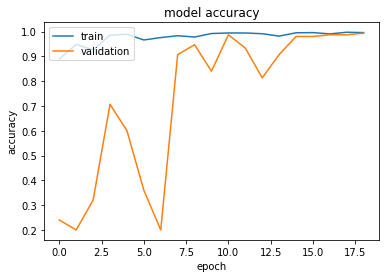

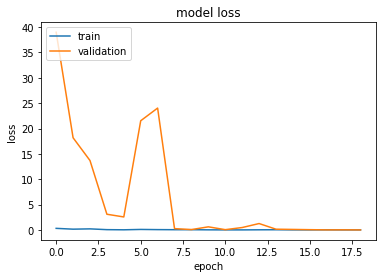

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# Save the model as a Keras model.
model.save('Wacayang_DenseNet_Model.h5')

In [ ]:
from keras.models import load_model
import cv2
import numpy as np
from keras.preprocessing import image
from google.colab.patches import cv2_imshow
from PIL import Image

classes = ['bagong', 'cepot', 'gareng', 'petruk', 'semar']

loaded_model = load_model('Wacayang_DenseNet_Model.h5')

image_testing = Image.open('/content/images/test/wayang_petruk_261.jpg')
image_testing = np.array(image_testing.resize((300, 300))) / 255.0
image_testing.shape

image_testing = np.expand_dims(image_testing, axis=0)
print(image_testing.shape)

output = model.predict(image_testing)
best_index = np.argmax(output)
class_name = classes[best_index]

print(output)
print(best_index)

(1, 300, 300, 3)
[[3.9708634e-13 4.2874775e-14 1.8354680e-08 1.0000000e+00 7.1592234e-14]]
3


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
cd /content/drive/MyDrive/Colab Notebooks/Wacayang

/content/drive/MyDrive/Colab Notebooks/Wacayang


In [14]:
from keras.models import load_model
loaded_model = load_model('Wacayang_DenseNet_Model.h5')

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

test_datagen = ImageDataGenerator(rescale = 1./255)  #Image normalization.
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/Colab Notebooks/Wacayang/test',
                                            target_size = (300, 300),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 150 images belonging to 5 classes.


In [16]:
score = loaded_model.evaluate(test_set, return_dict=True, verbose=0)
print(score)

{'loss': 0.018745819106698036, 'accuracy': 0.9866666793823242}
